# Digit recognition in Machine Learning with SVM classifier


## Desription

The MNSIT dataset is composed of a set of 42 000 images for trainging with a resolution of 28x28x1 in grayscale.


## Initialisation


### Load data

In [1]:
import pandas as pd

df_train = pd.read_csv("Datasets/train.csv")
y = df_train["label"]
X = df_train.drop("label", axis=1)

### Show images info


In [2]:
print(df_train.head())

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


### Plot images

Plot images as BW with reversed BW.


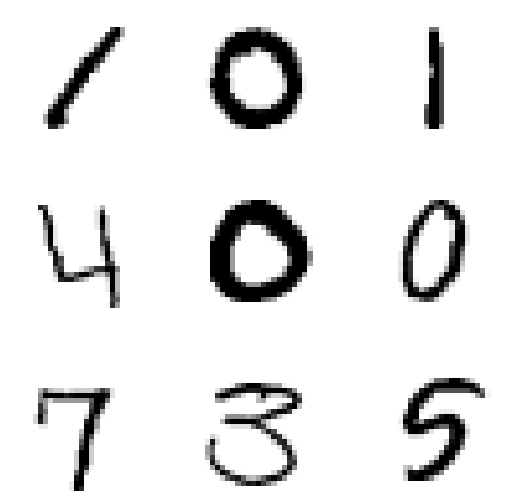

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X.iloc[i, 0:].values.reshape(28, 28), cmap=plt.cm.gray_r)
    plt.axis("off")
plt.show()

## Split data

In [5]:
from sklearn.model_selection import train_test_split

# No use now, handled by gridsearch
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Hyper-parameters tuning

In [6]:
### Hyper-parameters tuning and cross validation with data split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn import svm

steps = [('scaler', MinMaxScaler()), ('svc', svm.SVC())]
pipeline = Pipeline(steps)

grid_params = {'svc__C': [i for i in range(1, 20)], 'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']}

gsCV = GridSearchCV(pipeline, grid_params, verbose=4, cv=5)

In [7]:
print(gsCV.fit(X_train, y_train))

In [8]:
print(gsCV.best_estimator_)
print(gsCV.best_params_)
print(gsCV.best_score_)

## Predict on test set

In [9]:
from sklearn import svm

svc = svm.SVC(C=gsCV.best_params_['svc__C'], kernel=gsCV.best_params_['svc__kernel'])

svc.fit(X_train,y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)

Train accuracy: 0.9999702380952381.
Test accuracy: 0.9804761904761905.


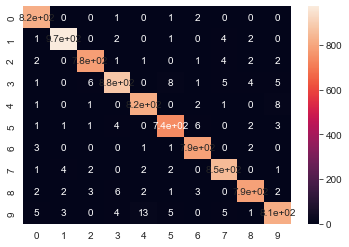

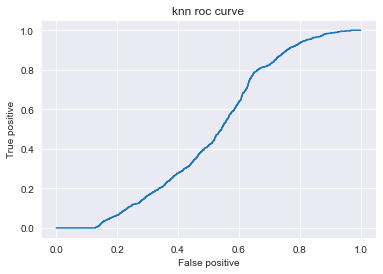

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns


# Accuracies
def print_scores(y_train, y_test, y_pred_train, y_pred_test):
    print(f"Train accuracy: {accuracy_score(y_train, y_pred_train)}.")
    print(f"Test accuracy: {accuracy_score(y_test, y_pred_test)}.")


# Confusion matrix
def print_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    plt.show()


# ROC curve
def print_roc_curve(model, X_test, y_test, name, title):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=9)
    plt.plot(fpr, tpr, label=name)
    plt.xlabel("False positive")
    plt.ylabel("True positive")
    plt.title(title)
    plt.show()


print_scores(y_train, y_test, y_pred_train, y_pred_test)
print_confusion_matrix(y_test, y_pred_test)
print_roc_curve(svc, X_test, y_test, "SVC", "svc roc curve")

## Images processing for true training and test

## Reload true data

In [11]:
X_train = X
y_train = y

df_test = pd.read_csv("Datasets/test.csv")
X_test = df_test
y_test = []  # Empty no labels for test data

## Scale data

In [12]:
from sklearn.preprocessing import MinMaxScaler

## Rescale to -1,+1 in our case 0,+1 because we only have positive pixels' value:
scale = MinMaxScaler()

# fit_transform() is used on the training data so that we can scale the training data and also learn the scaling parameters of that data.
X_train = scale.fit_transform(X_train)

# Using the transform method we can use the same mean and variance as it is calculated from our training data to transform our test data.
X_test = scale.transform(X_test)

## Data augmentation

In [13]:
from scipy.ndimage import shift
from scipy.ndimage import rotate
from scipy.ndimage import zoom
from random import randrange
import numpy as np


def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])


def rotate_image(image, angle):
    image = image.reshape((28, 28))
    rotated_image = rotate(image, angle, reshape=False)
    return rotated_image.reshape([-1])

# Thanks to the answers on the following thread for the function
# https://stackoverflow.com/questions/37119071/scipy-rotate-and-zoom-an-image-without-changing-its-dimensions
def clipped_zoom(img, zoom_factor):
    img = img.reshape((28,28))
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out.reshape([-1])


X_train_augmented = list(X_train)
y_train_augmented = list(y_train)

# Add shifted images
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

# Add rotated images
for image, label in zip(X_train, y_train):
    X_train_augmented.append(rotate_image(image, randrange(0, 28)))
    y_train_augmented.append(label)
    X_train_augmented.append(rotate_image(image, -randrange(0, 28)))
    y_train_augmented.append(label)

# # Add zoomed images
# for image, label in zip(X_train, y_train):
#     X_train_augmented.append(clipped_zoom(image, randrange(5, 16)/10))
#     y_train_augmented.append(label)

## Model creation

In [14]:
svc = svm.SVC(C=gsCV.best_params_['svc__C'], kernel=gsCV.best_params_['svc__kernel'])

## Train

In [15]:
print(svc.fit(X_train_augmented, y_train_augmented))

SVC(C=10.0)


## Predict

In [16]:
y_pred_real = svc.predict(X_test)

## Write predictions to csv

In [17]:
df_pred = pd.DataFrame({'ImageId': list(range(1, len(y_pred_real) + 1)), 'Label': y_pred_real})
df_pred.to_csv("Im-Rises_svc_main.csv", index=False)
print(df_pred.head())

# Score: 0.98175
# augmented data Score shift only: 0.98757
# augmented data Score2 shift and rotate: 0.98975
# augmented data Score2 shift, rotate and zoom: 0.98964


   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      0
4        5      3
